References:
* https://medium.com/@zhonghong9998/anomaly-detection-in-time-series-data-using-lstm-autoencoders-51fd14946fa3
* https://www.semanticscholar.org/paper/Unsupervised-Anomaly-Detection-in-Time-Series-Using-Provotar-Linder/8b07f61e5807ab23663360735eb6ed4ac0c0d6f2
* https://www.semanticscholar.org/paper/Anomaly-detection-in-rotating-machinery-using-based-Patra-Sethi/71d30898d623e17a1c3dd13ac902e00214093154


# Importing libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
# import helper function script
import script_EDA as scp

# Load Data

In [50]:
df = pd.read_csv('../all_flights_preprocessed_with_and_without_leaks.csv', index_col=0,sep=';')
df.head()

,Flight,ID,VALUE_FOB,VALUE_FOB_EXPECTED,VALUE_FOB_DIFF,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,TOTAL_FUEL_USED,FUEL_LOADED_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,LEAK_FLOW,TARGET
UTC_TIME,,,,,,,,,,,,,,,,,,,,
2016-08-26 06:37:00,37_16.0,16.0_F-RBAJ,37228.333333,36800.890320,-427.443014,623.952576,621.907532,626.026062,618.223511,2490.109680,39291.0,4017.0,1889.0,2656.0,2685.0,1871.0,12225.0,11892.0,0.16,1
2016-08-26 06:37:01,37_16.0,16.0_F-RBAJ,37229.435418,36799.774841,-429.660577,624.230164,622.183716,626.308105,618.503174,2491.225159,39291.0,4013.0,1889.0,2656.0,2684.0,1870.0,12228.0,11895.0,0.16,1
2016-08-26 06:37:02,37_16.0,16.0_F-RBAJ,37230.730430,36798.591370,-432.139060,624.506348,622.460754,626.624023,618.817505,2492.408630,39291.0,4009.0,1889.0,2656.0,2684.0,1870.0,12230.0,11896.0,0.16,1
2016-08-26 06:37:03,37_16.0,16.0_F-RBAJ,37229.565736,36797.446716,-432.119020,624.782471,622.771118,626.904785,619.094910,2493.553284,39291.0,4004.0,1889.0,2656.0,2684.0,1869.0,12232.0,11899.0,0.16,1
2016-08-26 06:37:04,37_16.0,16.0_F-RBAJ,37228.364136,36796.311584,-432.052551,625.091919,623.043701,627.182129,619.370667,2494.688416,39291.0,3999.0,1888.0,2656.0,2684.0,1869.0,12233.0,11903.0,0.16,1


## Preprocess data

In [51]:
# Filter the normal data
normal_data = df[df['TARGET'] == 0]
anomalous_data = df[df['TARGET'] == 1]

# Group the data by Flight
grouped = normal_data.groupby('Flight')

# Extract the flight indices
flight_indices = list(grouped.groups.keys())

# Train-Test Split on flight indices
train_indices, test_indices = train_test_split(flight_indices, test_size=0.2, random_state=42)

# Create train and test datasets based on the split flight indices, 20% of the flight data is used for testing
train_data = normal_data[normal_data['Flight'].isin(train_indices)].drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).values
test_data = normal_data[normal_data['Flight'].isin(test_indices)].drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).values

# Convert to numpy arrays if needed
train_data = np.array(train_data)
test_data = np.array(test_data)

## Standarize

In [52]:
# Normalize the data
scaler = StandardScaler()

normal_data_train_scaled = scaler.fit_transform(train_data)
normal_data_test_scaled = scaler.transform(test_data)

anomalous_data_scaled = scaler.transform(anomalous_data.drop(['Flight', 'ID', 'LEAK_FLOW', 'TARGET'], axis=1).values)



## Create custom Dataset

In [64]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 10  # You can adjust this value
train_sequences = create_sequences(normal_data_train_scaled, seq_length)
test_sequences = create_sequences(normal_data_test_scaled, seq_length)
anomalous_sequences = create_sequences(anomalous_data_scaled, seq_length)

# AutoEncoder arquitecture (in pytorch)

In [84]:
# Define the LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_length, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.seq_length = seq_length
        self.encoder = nn.LSTM(
            input_size=n_features, 
            hidden_size=embedding_dim,
            num_layers=1, 
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=embedding_dim,
            num_layers=1, 
            batch_first=True
        )
        self.output_layer = nn.Linear(embedding_dim, n_features)
        
    def forward(self, x):
        # Encoder
        _, (hidden, cell) = self.encoder(x)
        # Repeat hidden state
        hidden = hidden.repeat(self.seq_length, 1, 1).permute(1, 0, 2)
        # Decoder
        x, (hidden, cell) = self.decoder(hidden)
        # Apply output layer to match the original feature size
        x = self.output_layer(x)
        return x

In [85]:
# Training the model
def train_model(model, train_data, num_epochs=50, batch_size=64, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    
    for epoch in range(num_epochs):
        for i in range(0, len(train_data), batch_size):
            x_batch = train_data[i:i+batch_size]
            x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, x_batch)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [86]:
# Initialize the model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = train_sequences.shape[2]
model = LSTMAutoencoder(seq_length, n_features).to(device)

In [87]:
train_sequences.shape

(1079718, 10, 16)

In [89]:
# Train the model
train_model(model, train_sequences, num_epochs=4)



Epoch [1/4], Loss: 0.0008
Epoch [2/4], Loss: 0.0007
Epoch [3/4], Loss: 0.0006
Epoch [4/4], Loss: 0.0006


# Evaluate Model

In [92]:
# Evaluation function
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        data = torch.tensor(data, dtype=torch.float32).to(device)
        output = model(data)
        loss = nn.functional.mse_loss(output, data, reduction='none')
        loss = loss.mean(dim=2).mean(dim=1).cpu().numpy()
    return loss


def evaluate_model(model, data, batch_size=64):
    model.eval()
    losses = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            x_batch = data[i:i+batch_size]
            x_batch = torch.tensor(x_batch, dtype=torch.float32).to(device)
            output = model(x_batch)
            loss = nn.functional.mse_loss(output, x_batch, reduction='none')
            loss = loss.mean(dim=2).mean(dim=1).cpu().numpy()
            losses.extend(loss)
    return np.array(losses)

In [93]:
# Evaluate the model
normal_loss = evaluate_model(model, test_sequences)
anomalous_loss = evaluate_model(model, anomalous_sequences)

# Threshold for anomaly detection
threshold = np.percentile(normal_loss, 95)  # 95th percentile of normal data loss

# Detect anomalies
anomalies = anomalous_loss > threshold

print(f"Detected {anomalies.sum()} anomalies out of {len(anomalies)} anomalous sequences")

Detected 499397 anomalies out of 1204389 anomalous sequences


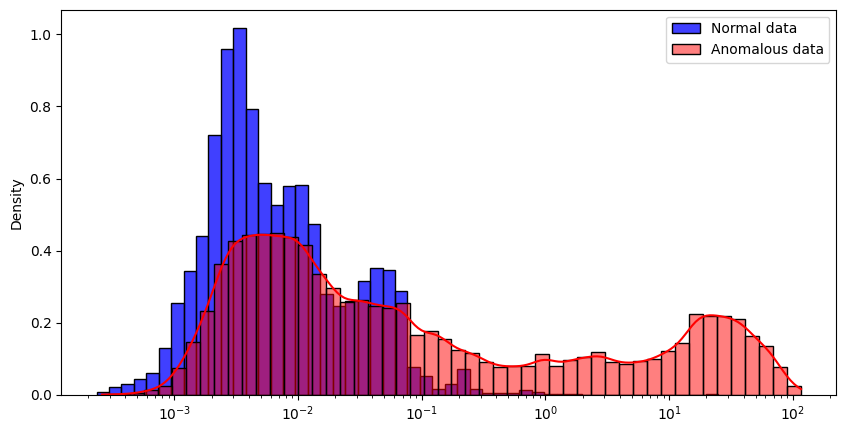

In [101]:
# Plot the loss distribution
plt.figure(figsize=(10, 5))
sns.histplot(normal_loss, kde=False, color='blue', label='Normal data',bins=50,log_scale=(True, False),stat='density')
sns.histplot(anomalous_loss, kde=True, color='red', label='Anomalous data',bins=50,log_scale=(True, False),stat='density')
plt.legend()
plt.show()